In [1]:
from srcmap import *
from mask import *
from stack import *
from utils_plotting import *
import seaborn as sns
sns.set()

In [2]:
inst = 1
make_srcmap_class = make_srcmap(inst, Re2 = 2, m_max=17)

In [3]:
mags = np.random.uniform(16, 17, len(make_srcmap_class.ms))
xls = np.random.uniform(0, 1023, len(make_srcmap_class.ms))
yls = np.random.uniform(0, 1023, len(make_srcmap_class.ms))

make_srcmap_class.ms = mags
make_srcmap_class.ms_inband = mags
make_srcmap_class.xls = xls
make_srcmap_class.yls = yls

In [4]:
mzmask, mznum = MZ14_mask(inst, xls, yls, mags)
clear_output()

srcmap = make_srcmap_class.run_srcmap(ptsrc=True)
modmap = make_srcmap_class.run_srcmap(ptsrc=False)

clear_output()

In [6]:
stack_class = stacking_mock(inst, make_srcmap_class.m_min, make_srcmap_class.m_max)
stack_class.xls = xls
stack_class.yls = yls

stacks, maskstacks, mapstacks = stack_class.run_stacking\
(srcmap - np.mean(srcmap[mzmask==1]), mzmask, mznum)

stackm, maskstackm, mapstackm = stack_class.run_stacking\
(modmap - np.mean(modmap[mzmask==1]), mzmask, mznum)

clear_output()

In [17]:
# data
dx = make_srcmap_class.dx
profstacks = radial_prof(stacks, dx, dx)
profstackm = radial_prof(stackm, dx, dx)

#model
psf_map = make_srcmap_class.psf_map
mod_map = make_srcmap_class.modconv_map
pix_map = make_srcmap_class.pix_map
Npad = (psf_map.shape[0] - pix_map.shape[0])//2
pix_map = np.pad(pix_map, ((Npad,Npad),(Npad,Npad)), 'constant')
psfwin_map = fftconvolve(psf_map, pix_map, 'same')
modwin_map = fftconvolve(mod_map, pix_map, 'same')
profmodelm = radial_prof(modwin_map, dx, dx)
profmodels = radial_prof(psfwin_map, dx, dx)

# excess
r_arr = profmodels['rbins']
stackex_arr = profstackm['prof']/profstackm['prof'][0] - profstacks['prof']/profstacks['prof'][0]
modelex_arr = profmodelm['prof']/profmodelm['prof'][0] - profmodels['prof']/profmodels['prof'][0]

make_srcmap_class1 = make_srcmap(inst, Re2 = 1.5, m_max=17)
modwin_map1 = fftconvolve(make_srcmap_class1.modconv_map, pix_map, 'same')
profmodelm1 = radial_prof(modwin_map1, dx, dx)
modelex_arr1 = profmodelm1['prof']/profmodelm1['prof'][0] - profmodels['prof']/profmodels['prof'][0]

make_srcmap_class2 = make_srcmap(inst, Re2 = 2.5, m_max=17)
modwin_map2 = fftconvolve(make_srcmap_class2.modconv_map, pix_map, 'same')
profmodelm2 = radial_prof(modwin_map2, dx, dx)
modelex_arr2 = profmodelm2['prof']/profmodelm2['prof'][0] - profmodels['prof']/profmodels['prof'][0]

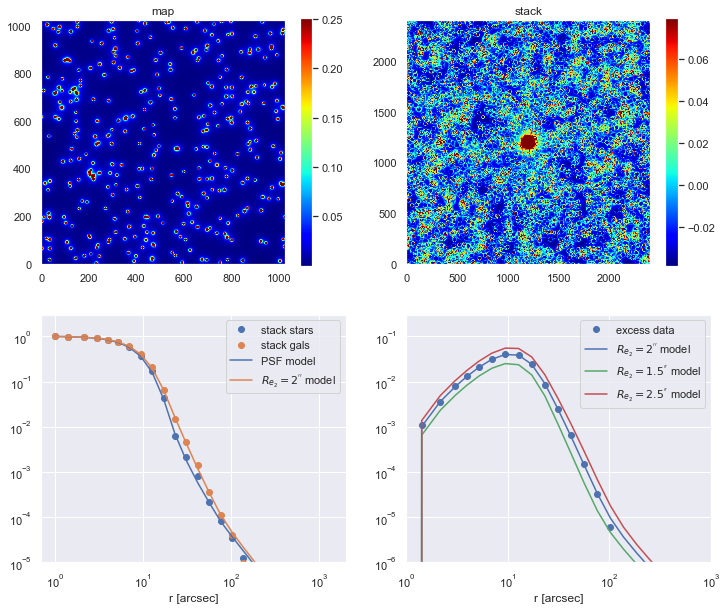

In [21]:
fig, ax = plt.subplots(2,2,figsize=(12,10))

imageclip(srcmap, ax=ax[0][0])
ax[0][0].set_title('map')
ax[0][0].grid(False)
imageclip(stacks, ax=ax[0][1])
ax[0][1].set_title('stack')
ax[0][1].grid(False)

ax[1][0].loglog(r_arr,profstacks['prof']/profstacks['prof'][0],'C0o',label='stack stars')
ax[1][0].loglog(r_arr,profstackm['prof']/profstackm['prof'][0],'C1o',label='stack gals')
ax[1][0].loglog(r_arr,profmodels['prof']/profmodels['prof'][0],'C0',
             label='PSF model')
ax[1][0].loglog(r_arr,profmodelm['prof']/profmodelm['prof'][0],'C1',
             label=r"$R_{e_2}=2^{''}$ model")
ax[1][0].set_ylim([1e-5,3e0])
ax[1][0].set_xlabel('r [arcsec]')
ax[1][0].legend()

ax[1][1].loglog(r_arr,stackex_arr,'C0o',label='excess data')
ax[1][1].loglog(r_arr,modelex_arr,'C0',label=r"$R_{e_2}=2^{''}$ model")
ax[1][1].loglog(r_arr,modelex_arr1,'C2',label=r"$R_{e_2}=1.5^{''}$ model")
ax[1][1].loglog(r_arr,modelex_arr2,'C3',label=r"$R_{e_2}=2.5^{''}$ model")

ax[1][1].set_ylim([1e-6,3e-1])
ax[1][1].set_xlim([1e0,1e3])
ax[1][1].legend()
ax[1][1].set_xlabel('r [arcsec]')
plt.savefig('plots/fitting_process_test.png', dpi = 100, bbox_inches='tight')

In [163]:
from srcmap import *
from mask import *
from stack import *
from utils_plotting import *

In [164]:
inst = 1
make_srcmap_class = make_srcmap(inst)

In [170]:
srcdat = ps_src_select(1,8, -5,40, 
    [np.ones([1024,1024]), np.ones([1024,1024])], sample_type='all')

In [208]:
# xg_arr, xs_arr = srcdat['xg_arr'], srcdat['xs_arr']
# yg_arr, ys_arr = srcdat['yg_arr'], srcdat['ys_arr']
xg_arr = np.random.uniform(513, 1023, 300)
xs_arr = np.random.uniform(0, 1023, 300)
xy_arr = np.random.uniform(0, 1023, 300)
xs_arr = np.random.uniform(0, 1023, 300)
mg_arr = np.random.uniform(16, 20, 300)
ms_arr = np.random.uniform(16, 20, 300)

# sp = np.where((xls>-0.5) & (xls<1023.5) & (yls>-0.5) & (yls<1023.5))[0]
# xls, yls, mags = xls[sp], yls[sp], mags[sp]

xls = np.concatenate((xg_arr, xs_arr))
yls = np.concatenate((yg_arr, ys_arr))
mags = np.concatenate((mg_arr, ms_arr))


make_srcmap_class.ms = mags
make_srcmap_class.ms_inband = mags
make_srcmap_class.xls = xls
make_srcmap_class.yls = yls

# mask, num = Ith_mask_mock(make_srcmap_class.xls,
#                           make_srcmap_class.yls, mags, verbose=True)
# clear_output()

# srcmap = make_srcmap_class.run_srcmap(ptsrc=True)
# clear_output()


In [211]:
from reduction import *
data_maps = {1: image_reduction(1), 2: image_reduction(2)}

In [232]:
inst = 1
ifield = 7
srcmap, mask, num, mean_ps = load_processed_images(data_maps, return_names=[(inst,ifield,'psmap'),
                                                                 (inst,ifield,'strmask'),
                                                                  (inst,ifield,'strnum'),
                                                                (inst,ifield,'mean_ps')])
srcmap += mean_ps
srcdat = ps_src_select(inst, ifield, 19,20,
    [np.ones([1024,1024]), np.ones([1024,1024])], sample_type='all')

In [235]:
stack_class = stacking_mock(inst, m_min, m_max)
xls = srcdat['xs_arr']
yls = srcdat['ys_arr']
mags = srcdat['ms_arr']

stack_class.xls = xls[:200]
stack_class.yls = yls[:200]

stackdat = stack_class.run_stacking\
(srcmap - np.mean(srcmap[mask==1]), mask, num)

clear_output()

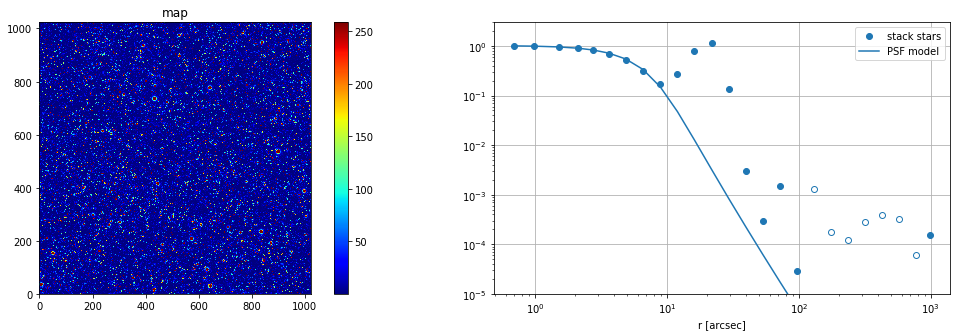

In [236]:
# data
dx = make_srcmap_class.dx
rbins = stackdat['rbins']
profstacks = stackdat['prof']

#model
psf_map = make_srcmap_class.psf_map
pix_map = make_srcmap_class.pix_map
Npad = (psf_map.shape[0] - pix_map.shape[0])//2
pix_map = np.pad(pix_map, ((Npad,Npad),(Npad,Npad)), 'constant')
psfwin_map = fftconvolve(psf_map, pix_map, 'same')
profmodels = radial_prof(psfwin_map, dx, dx)['prof']

fig, ax = plt.subplots(1,2,figsize=(18,5))

imageclip(srcmap, ax=ax[0])
ax[0].set_title('map')
ax[0].grid(False)

ax[1].loglog(rbins,profstacks/profstacks[0],'C0o',label='stack stars')
ax[1].loglog(rbins,-profstacks/profstacks[0],'C0o', fillstyle='none')
ax[1].loglog(rbins,profmodels/profmodels[0],'C0', label='PSF model')
ax[1].grid()
ax[1].set_ylim([1e-5,3e0])
ax[1].set_xlabel('r [arcsec]')
ax[1].legend()

# plt.savefig('plots/fitting_process_test.png', dpi = 100, bbox_inches='tight')

In [190]:
m_min, m_max = 16,17
stack_class = stacking_mock(inst, m_min, m_max)
xls = srcdat['xs_arr']
yls = srcdat['ys_arr']
mags = srcdat['ms_arr']
sp = np.where((mags >= m_min) & (mags < m_max))[0]

stack_class.xls = xls[:50]
stack_class.yls = yls[:50]

stackdat = stack_class.run_stacking\
(srcmap - np.mean(srcmap[mask==1]), mask, num)

clear_output()

In [191]:
# data
dx = make_srcmap_class.dx
rbins = stackdat['rbins']
profstacks = stackdat['prof']

#model
psf_map = make_srcmap_class.psf_map
pix_map = make_srcmap_class.pix_map
Npad = (psf_map.shape[0] - pix_map.shape[0])//2
pix_map = np.pad(pix_map, ((Npad,Npad),(Npad,Npad)), 'constant')
psfwin_map = fftconvolve(psf_map, pix_map, 'same')
profmodels = radial_prof(psfwin_map, dx, dx)['prof']

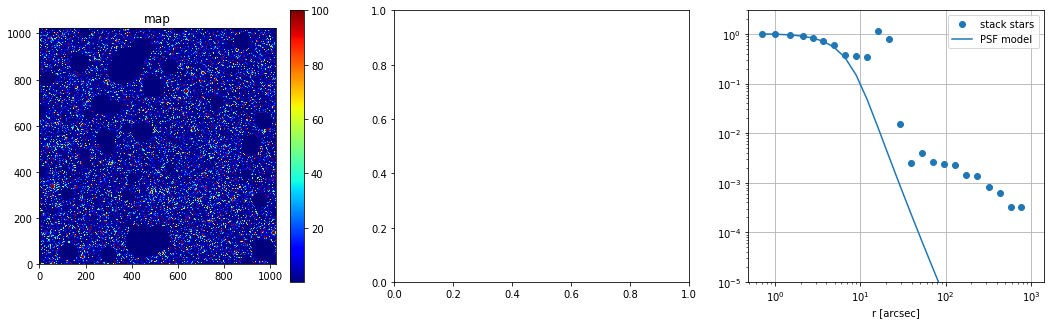

In [192]:
fig, ax = plt.subplots(1,3,figsize=(18,5))

imageclip(srcmap, ax=ax[0])
ax[0].set_title('map')
ax[0].grid(False)

ax[2].loglog(rbins,profstacks/profstacks[0],'C0o',label='stack stars')
ax[2].loglog(rbins,-profstacks/profstacks[0],'C0o', fillstyle='none')
ax[2].loglog(rbins,profmodels/profmodels[0],'C0', label='PSF model')
ax[2].grid()
ax[2].set_ylim([1e-5,3e0])
ax[2].set_xlabel('r [arcsec]')
ax[2].legend()

# plt.savefig('plots/fitting_process_test.png', dpi = 100, bbox_inches='tight')

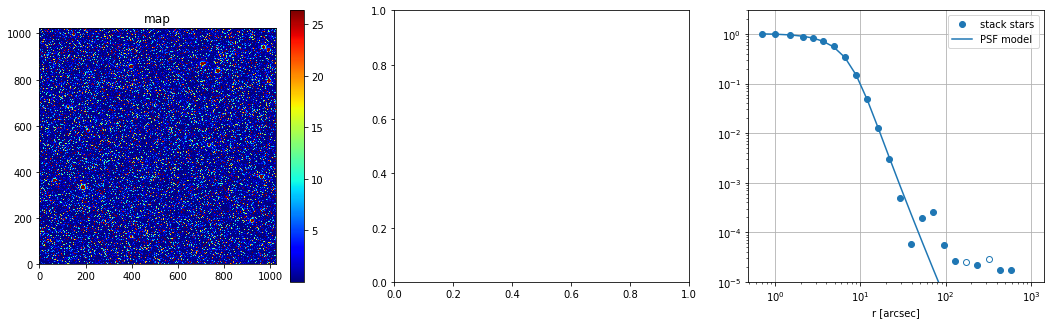

In [148]:
fig, ax = plt.subplots(1,3,figsize=(18,5))

imageclip(srcmap, ax=ax[0])
ax[0].set_title('map')
ax[0].grid(False)

ax[2].loglog(rbins,profstacks/profstacks[0],'C0o',label='stack stars')
ax[2].loglog(rbins,-profstacks/profstacks[0],'C0o', fillstyle='none')
ax[2].loglog(rbins,profmodels/profmodels[0],'C0', label='PSF model')
ax[2].grid()
ax[2].set_ylim([1e-5,3e0])
ax[2].set_xlabel('r [arcsec]')
ax[2].legend()

# plt.savefig('plots/fitting_process_test.png', dpi = 100, bbox_inches='tight')

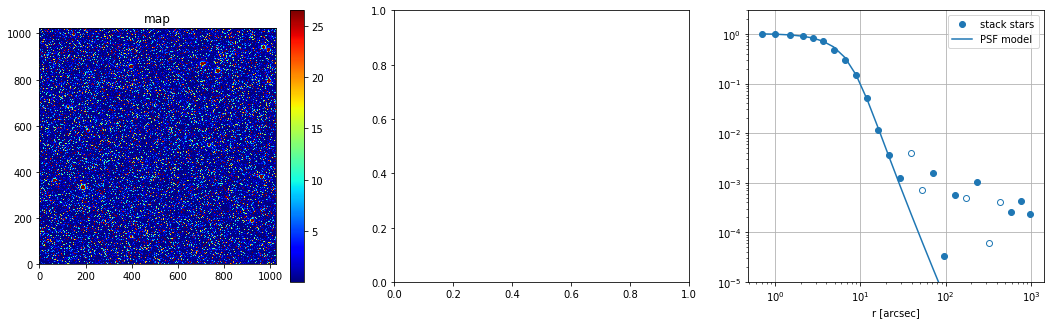

In [93]:
fig, ax = plt.subplots(1,3,figsize=(18,5))

imageclip(srcmap, ax=ax[0])
ax[0].set_title('map')
ax[0].grid(False)

ax[2].loglog(rbins,profstacks/profstacks[0],'C0o',label='stack stars')
ax[2].loglog(rbins,-profstacks/profstacks[0],'C0o', fillstyle='none')
ax[2].loglog(rbins,profmodels/profmodels[0],'C0', label='PSF model')
ax[2].grid()
ax[2].set_ylim([1e-5,3e0])
ax[2].set_xlabel('r [arcsec]')
ax[2].legend()

# plt.savefig('plots/fitting_process_test.png', dpi = 100, bbox_inches='tight')

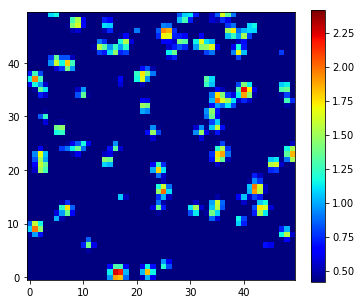

In [162]:
mean_ps = np.mean(srcmap[mask==1])
imageclip(np.log10(srcmap[:50,:50]), vmin=mean_ps-1, vmax=mean_ps +1)

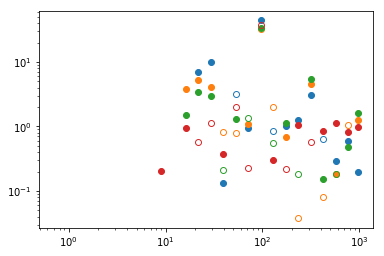

In [142]:
for im,m_min in enumerate([16,17,18,19]):
    m_max = m_min + 1
    xls = make_srcmap_class.xls
    yls = make_srcmap_class.yls
    mags = make_srcmap_class.ms
    sp = np.where((mags >= m_min) & (mags < m_max))[0]
    
    if len(sp) > 100:
        sp = sp[:100]
    stack_class.xls = xls[sp]
    stack_class.yls = yls[sp]
    stackdat1 = stack_class.run_stacking_bigpix\
    (srcmap - np.mean(srcmap[mask==1]), mask, num)
    clear_output()

    profstacks = stackdat1['prof']
    plt.loglog(rbins,profstacks/stackdat['prof'],'o', c='C'+str(im), label='stack stars')
    plt.loglog(rbins,-profstacks/stackdat['prof'],'o',  c='C'+str(im), fillstyle='none')